# Jerk, jounce, etc.

This notebook accompanies a blog post on [Agile](https://agilescintific.com/blog/2018/3/6/jounce-crackle-and-pop).

First, the usual preliminaries...

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set()

## Load the data

This dataset is from this (slightly weird) blog post https://www.duckware.com/blog/tesla-elon-musk-nytimes-john-broder-feud/index.html. It was the only decent bit of telemetry data I could find. I doubt it's properly licensed. If you have access to any open data — maybe from a Formula 1 car, or maybe your own vehicle, I'd love to know about it!

In [3]:
data = np.loadtxt('data/tesla_speed.csv', delimiter=',')

Convert `x` to m and `v` to m/s, per the instructions in the blog post about the dataset (modified for metric units).

In [4]:
x = (data[:, 0] + 3) * 2.05404
x = x - np.min(x)
v_x = np.mean(data[:, 1:], axis=1) * 0.0380610

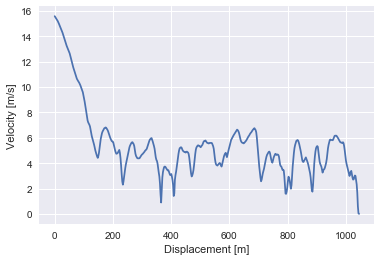

In [5]:
plt.plot(x, v_x)
plt.xlabel('Displacement [m]')
plt.ylabel('Velocity [m/s]')
plt.show()

Note that the sampling was done per unit of displacement; we'd really prefer time. Let's convert it!

## Time conversion

Convert to the time domain, since we want derivatives with respect to time, not distance.

In [6]:
elapsed_time = np.cumsum(1 / v_x)

/Users/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


Adjust the last entry, to avoid a very long interval.

In [7]:
elapsed_time[-1] = 2 * elapsed_time[-2] - elapsed_time[-3]

In [8]:
t = np.linspace(0, elapsed_time[-1], 1000)

In [9]:
v_t = np.interp(t, elapsed_time, v_x)

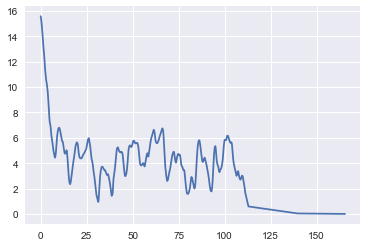

In [10]:
plt.plot(t, v_t)
plt.show()

## Compute integrals

Use trapezoidal integral approximation, https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.cumtrapz.html

In [11]:
import scipy.integrate

# Displacement, d
d = scipy.integrate.cumtrapz(v_t, t, initial=0)

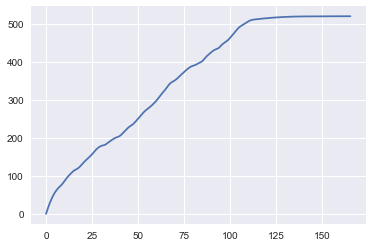

In [12]:
plt.plot(t, d)
plt.show()

In [13]:
# Absement
abt = scipy.integrate.cumtrapz(d, t, initial=0)

# Absity
aby = scipy.integrate.cumtrapz(abt, t, initial=0)

# Abseleration
abn = scipy.integrate.cumtrapz(aby, t, initial=0)

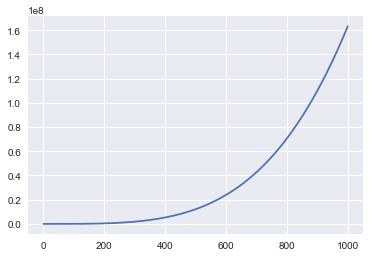

In [14]:
plt.plot(abn)
plt.show()

That's a boring graph!

## Check that derivative of displacement gives back velocity

Use Savitsky-Golay filter for differentiation with some smoothing: https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

In [15]:
import scipy.signal

In [16]:
dt = t[1] - t[0]

In [17]:
# Check that Savitsky-Golay filter gives velocity from d/dt displacement.
v_ = scipy.signal.savgol_filter(d, delta=dt, window_length=3, polyorder=2, deriv=1)

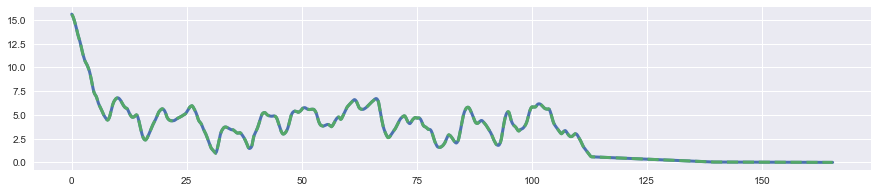

In [18]:
plt.figure(figsize=(15, 3))
plt.plot(t, v_, lw=3)
plt.plot(t, v_t, '--', lw=3)

It does: we seem to be computing integrals properly.

## Compute derivatives

In [19]:
# Acceleration
a = scipy.signal.savgol_filter(v_t, delta=dt, window_length=11, polyorder=2, deriv=1)

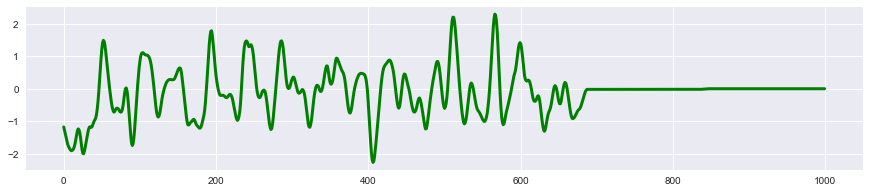

In [20]:
plt.figure(figsize=(15,3))
plt.plot(a, lw=3, color='green')
plt.axhline(c='k', lw=0.5, zorder=0)
plt.show()

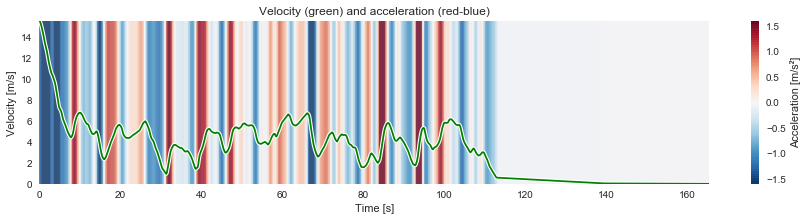

In [21]:
plt.figure(figsize=(15,3))
plt.imshow([a], cmap='RdBu_r', vmin=-1.6, vmax=1.6, alpha=0.8,
           aspect='auto', extent=[t.min(), t.max(), v_t.min(), v_t.max()])
plt.colorbar(label="Acceleration [m/s²]")
plt.plot(t, v_t, 'white', lw=4)
plt.plot(t, v_t, 'green')
plt.title("Velocity (green) and acceleration (red-blue)")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.grid('off')
plt.show()

## Jerk, jounce, and so on

In [22]:
j = scipy.signal.savgol_filter(v_t, delta=dt, window_length=11, polyorder=2, deriv=2)
s = scipy.signal.savgol_filter(v_t, delta=dt, window_length=15, polyorder=3, deriv=3)
c = scipy.signal.savgol_filter(v_t, delta=dt, window_length=19, polyorder=4, deriv=4)
p = scipy.signal.savgol_filter(v_t, delta=dt, window_length=23, polyorder=5, deriv=5)

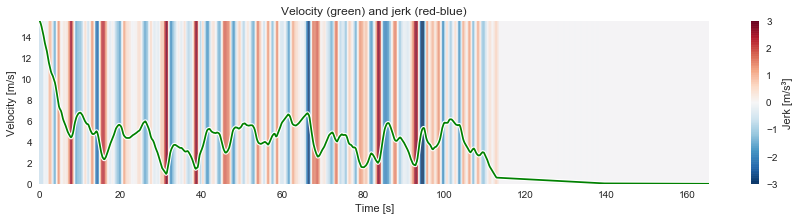

In [23]:
plt.figure(figsize=(15,3))
plt.imshow([j], cmap='RdBu_r', vmin=-3, vmax=3, alpha=0.8,
           aspect='auto', extent=[t.min(), t.max(), v_t.min(), v_t.max()])
plt.colorbar(label="Jerk [m/s³]")
plt.plot(t, v_t, 'white', lw=4)
plt.plot(t, v_t, 'green')
plt.title("Velocity (green) and jerk (red-blue)")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.grid('off')
plt.show()

## Plot everything!

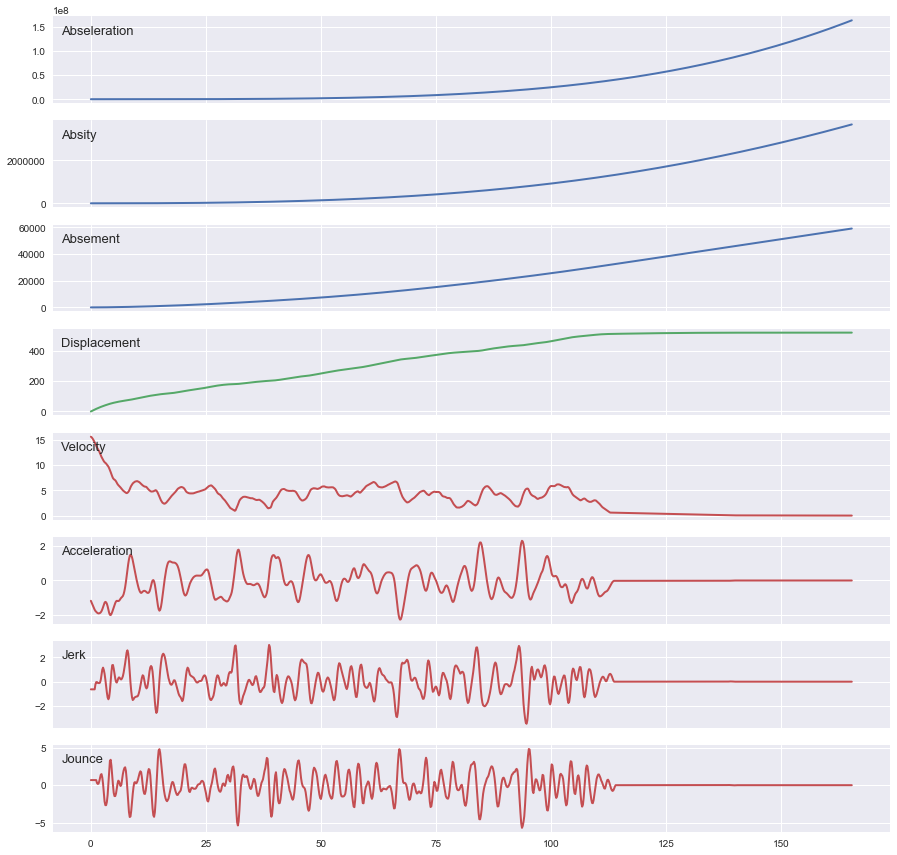

In [24]:
plots = {
    'Abseleration': abn,
    'Absity': aby,
    'Absement': abt,
    'Displacement': d,
    'Velocity': v_t,
    'Acceleration': a,
    'Jerk': j,
    'Jounce': s,
#    'Crackle': c,
#    'Pop': p,    
}

colors = ['C0', 'C0', 'C0', 'C1', 'C2', 'C2', 'C2', 'C2']

fig, axs = plt.subplots(figsize=(15,15), nrows=len(plots))
pos = 0.01, 0.8
params = dict(fontsize=13)

for i, (k, v) in enumerate(plots.items()):
    ax = axs[i]
    ax.plot(t, v, lw=2, color=colors[i])
    ax.text(*pos, k, transform=ax.transAxes, **params)
#     if np.min(v) < 0:
#         ax.axhline(color='k', lw=0.5, zorder=0)
    if i < len(plots)-1:
        ax.set_xticklabels([])

plt.show()

<hr>

© 2018 Agile Scientific — licensed CC-BY